<a href="https://colab.research.google.com/github/mmobbili/mmobbili/blob/main/Viscosity_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup - Imports

In [ ]:
!pip install pubchempy

  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13834 sha256=bd68199be013a9e816808ffa7ab04accbf49da3fa75b69fe2d91eb281210f790
  Stored in directory: /root/.cache/pip/wheels/7c/3d/8c/8192697412e9899dc55bbbb08bbc1197bef333caaa2a71c448
Successfully built pubchempy


In [ ]:
!pip install --pre deepchem

     |████████████████████████████████| 608 kB 19.8 MB/s 
     |████████████████████████████████| 22.7 MB 1.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pubchempy as pcp
import deepchem as dc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import rdkit as rd
from time import sleep
import dill

In [ ]:
paper_dir = '/content/drive/MyDrive/GridX - Data Science/'+\
'Backup Data Bioeutectics/IA BioEutectics GRIDX/3.Modelo de  Optimización/'+ \
'Bibliografia_ML_NADES/Density_Viscosity_prediction_2020/'

os.listdir(paper_dir)

['density_viscosity_hydrophobic_eutectic_solvents_2020.pdf',
 'density_viscosity_hydrophobic_eutectic_solvents_2020_suppl_info.pdf',
 'density_viscosity_hydrophobic_eutectic_solvents_2020_suppl_info-converted 1.0.txt',
 'density_viscosity_hydrophobic_eutectic_solvents_2020_suppl_info-converted 1.0.xlsx',
 'density_visc_v1.csv',
 'density_experiments.csv',
 'viscosity_experiments.csv',
 'all_compounds.gsheet',
 'all_compounds.tsv',
 'deepchem_dataset']

### EDA

In [ ]:
visc = pd.read_csv(os.path.join(paper_dir,'viscosity_experiments.csv'))
visc.head()

,description,experiment_id,comp_a,comp_b,N_a,N_b,T_visc,visc
0,HES1- Decanoic Acid : Tetrabutylammonium Chlor...,HES1,Decanoic Acid,Tetrabutylammonium Chloride,2.0,1.0,288.2,526.39
1,HES1- Decanoic Acid : Tetrabutylammonium Chlor...,HES1,Decanoic Acid,Tetrabutylammonium Chloride,2.0,1.0,293.2,368.54
2,HES1- Decanoic Acid : Tetrabutylammonium Chlor...,HES1,Decanoic Acid,Tetrabutylammonium Chloride,2.0,1.0,298.2,265.26
3,HES1- Decanoic Acid : Tetrabutylammonium Chlor...,HES1,Decanoic Acid,Tetrabutylammonium Chloride,2.0,1.0,303.2,195.05
4,HES1- Decanoic Acid : Tetrabutylammonium Chlor...,HES1,Decanoic Acid,Tetrabutylammonium Chloride,2.0,1.0,308.2,146.16


In [ ]:
visc['T_visc_jitter'] = visc['T_visc'] + 0.7*np.random.randn((len(visc)))

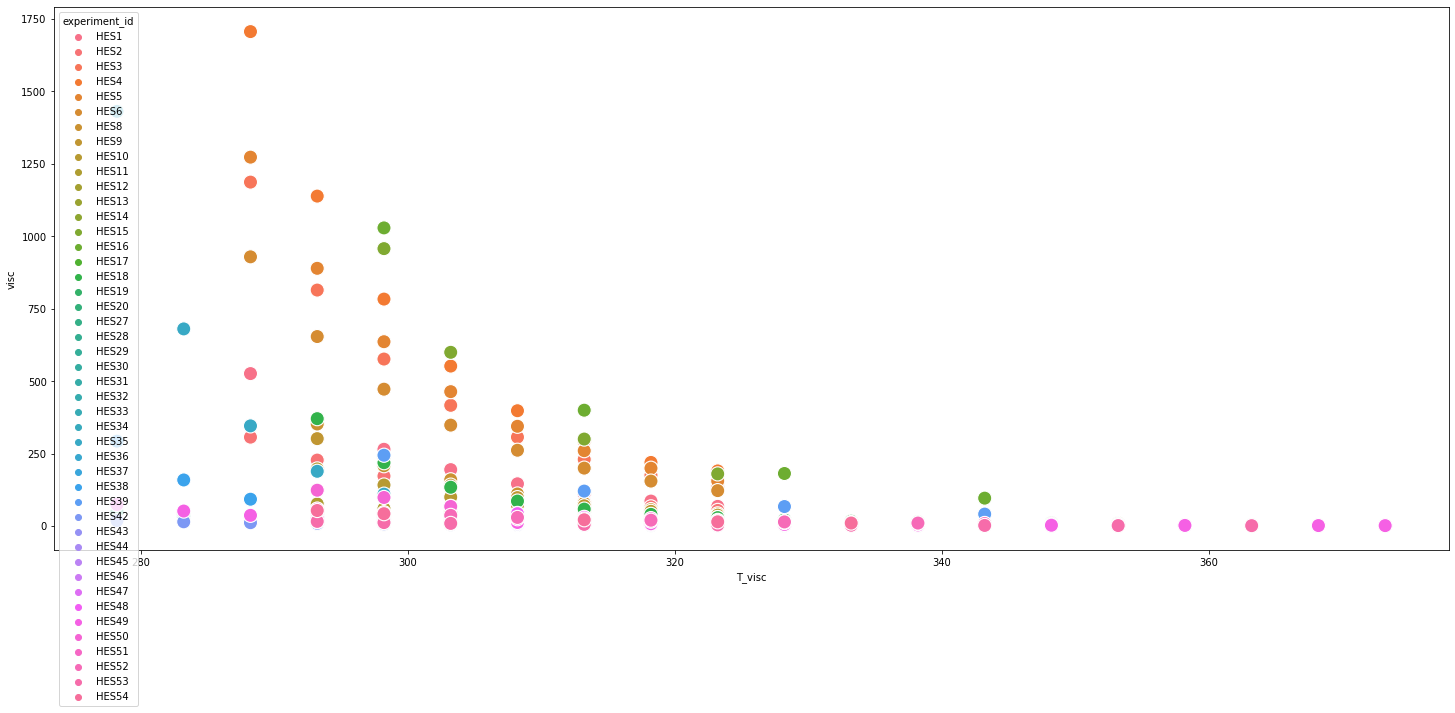

In [ ]:
plt.figure(figsize = (25, 10))
sns.scatterplot(x = 'T_visc', y = 'visc',
                hue = 'experiment_id', data = visc,
                s = 200, alpha = 1)

In [ ]:
help(featurizer)

Help on ConvMolFeaturizer in module deepchem.feat.graph_features object:

class ConvMolFeaturizer(deepchem.feat.base_classes.MolecularFeaturizer)
 |  ConvMolFeaturizer(master_atom: bool = False, use_chirality: bool = False, atom_properties: Iterable[str] = [], per_atom_fragmentation: bool = False)
 |  
 |  This class implements the featurization to implement Duvenaud graph convolutions.
 |  
 |  Duvenaud graph convolutions [1]_ construct a vector of descriptors for each
 |  atom in a molecule. The featurizer computes that vector of local descriptors.
 |  
 |  Examples
 |  ---------
 |  >>> import deepchem as dc
 |  >>> smiles = ["C", "CCC"]
 |  >>> featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
 |  >>> f = featurizer.featurize(smiles)
 |  >>> # Using ConvMolFeaturizer to create featurized fragments derived from molecules of interest.
 |  ... # This is used only in the context of performing interpretation of models using atomic
 |  ... # contributions (atom-based mod

In [ ]:
featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)

In [ ]:
os.listdir(paper_dir)

['density_viscosity_hydrophobic_eutectic_solvents_2020.pdf',
 'density_viscosity_hydrophobic_eutectic_solvents_2020_suppl_info.pdf',
 'density_viscosity_hydrophobic_eutectic_solvents_2020_suppl_info-converted 1.0.txt',
 'density_viscosity_hydrophobic_eutectic_solvents_2020_suppl_info-converted 1.0.xlsx',
 'density_visc_v1.csv',
 'density_experiments.csv',
 'viscosity_experiments.csv',
 'all_compounds.gsheet',
 'all_compounds.tsv',
 'deepchem_dataset']

In [ ]:
comp_lkp = pd.read_csv(os.path.join(paper_dir, 'all_compounds.tsv'),
                       sep = '\t')
comp_lkp.head()

,compound_name_in_article,comps_list,list_len,canonical_smiles,cid,iupac_name,molecular_formula
0,3-Hydroxy Benzoic Acid,[Compound(7420)],1,C1=CC(=CC(=C1)O)C(=O)O,7420,3-hydroxybenzoic acid,C7H6O3
1,Phenol,[Compound(996)],1,C1=CC=C(C=C1)O,996,phenol,C6H6O
2,Sesamol,[Compound(68289)],1,C1OC2=C(O1)C=C(C=C2)O,68289,"1,3-benzodioxol-5-ol",C7H6O3
3,Pyruvic Acid,[Compound(1060)],1,CC(=O)C(=O)O,1060,2-oxopropanoic acid,C3H4O3
4,Acetic Acid,[Compound(176)],1,CC(=O)O,176,acetic acid,C2H4O2


In [ ]:
help(featurizer.featurize)

Help on method featurize in module deepchem.feat.graph_features:

featurize(datapoints: Union[Any, str, Iterable[Any], Iterable[str]], log_every_n: int = 1000, **kwargs) -> numpy.ndarray method of deepchem.feat.graph_features.ConvMolFeaturizer instance
    Override parent: aim is to add handling atom-depleted molecules featurization
    
    Parameters
    ----------
    datapoints: rdkit.Chem.rdchem.Mol / SMILES string / iterable
      RDKit Mol, or SMILES string or iterable sequence of RDKit mols/SMILES
      strings.
    log_every_n: int, default 1000
      Logging messages reported every `log_every_n` samples.
    
    Returns
    -------
    features: np.ndarray
      A numpy array containing a featurized representation of `datapoints`.



In [ ]:
comps_features = featurizer.featurize(comp_lkp.canonical_smiles)

In [ ]:
conv_mol_X = pd.DataFrame({'ConvMol' : comps_features,
              'cid': comp_lkp.cid})

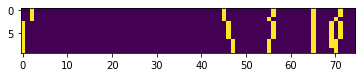

In [ ]:
plt.imshow(comps_features[0].atom_features)

In [ ]:
pcp_comps = []

for ix in comp_lkp.cid:
  pcp_comps.append(pcp.Compound.from_cid(ix))
  sleep(0.5)

In [ ]:
comp_xlogp = pcp.compounds_to_frame(pcp_comps, properties = ['xlogp']).reset_index()

In [ ]:
conv_mol_X_y = pd.concat([conv_mol_X, comp_xlogp[['xlogp']]], axis = 1)

In [ ]:
conv_mol_X_y.dropna(subset = ['xlogp'], inplace = True)

In [ ]:
conv_mol_X_y.head()

,ConvMol,cid,xlogp
0,<deepchem.feat.mol_graphs.ConvMol object at 0x...,7420,1.5
1,<deepchem.feat.mol_graphs.ConvMol object at 0x...,996,1.5
2,<deepchem.feat.mol_graphs.ConvMol object at 0x...,68289,1.2
3,<deepchem.feat.mol_graphs.ConvMol object at 0x...,1060,-0.3
4,<deepchem.feat.mol_graphs.ConvMol object at 0x...,176,-0.2


In [ ]:
comp_lkp_xlogp = pd.merge(comp_lkp,
                          conv_mol_X_y,
                          on = 'cid')

In [ ]:
comp_lkp_xlogp.shape

(26, 9)

### Delaney Dataset

In [ ]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')

In [ ]:
train, _, _ = datasets

In [ ]:
train_smiles = list(train.ids)

In [ ]:
help(pcp.get_compounds)

Help on function get_compounds in module pubchempy:

get_compounds(identifier, namespace='cid', searchtype=None, as_dataframe=False, **kwargs)
    Retrieve the specified compound records from PubChem.
    
    :param identifier: The compound identifier to use as a search query.
    :param namespace: (optional) The identifier type, one of cid, name, smiles, sdf, inchi, inchikey or formula.
    :param searchtype: (optional) The advanced search type, one of substructure, superstructure or similarity.
    :param as_dataframe: (optional) Automatically extract the :class:`~pubchempy.Compound` properties into a pandas
                         :class:`~pandas.DataFrame` and return that.



In [ ]:
(900)/60

15.0

In [ ]:
pcp_train_comps = []
for i, smile in enumerate(train_smiles):
  #sleep(0.1)
  pcp_train_comps.append(pcp.get_compounds(smile, namespace = 'smiles')[0])
  if (i+1) % 50 == 0:
    print(f'Voy por el nro: {i+1}')

Voy por el nro: 50
Voy por el nro: 100
Voy por el nro: 150
Voy por el nro: 200
Voy por el nro: 250
Voy por el nro: 300
Voy por el nro: 350
Voy por el nro: 400
Voy por el nro: 450
Voy por el nro: 500
Voy por el nro: 550
Voy por el nro: 600
Voy por el nro: 650
Voy por el nro: 700
Voy por el nro: 750
Voy por el nro: 800
Voy por el nro: 850
Voy por el nro: 900


In [ ]:
pcp_train_comps[:4]

[Compound(8843), Compound(8004), Compound(12389), Compound(6361)]

In [ ]:
[c.cid for c in pcp_train_comps][:5]

[8843, 8004, 12389, 6361, 8723]

In [ ]:
train_dict = {'smiles' : train_smiles
              ,'X' : train.X
              ,'cid' : [c.cid for c in pcp_train_comps]
              ,'pcp_comp' : pcp_train_comps
              ,'y' : train.y.squeeze()
              ,'xlogp': [c.xlogp for c in pcp_train_comps]
              }

In [ ]:
train_df = pd.DataFrame(train_dict)

In [ ]:
with open(os.path.join(paper_dir,'delaney_datasets','train_dict.pkl'),'wb') as fp:
  dill.dump(train_df, fp)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
train_df.dropna(subset = ['xlogp'], inplace = True)

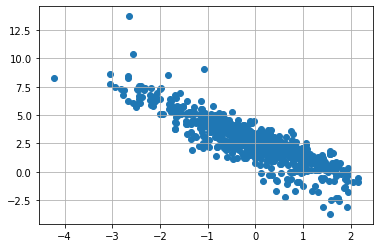

In [ ]:
# Relacion entre xlogp de pubchem y la "y" de deepchem
_ = plt.scatter(train_df['y'], train_df['xlogp'])
plt.grid()

In [ ]:
train_df.xlogp.values.shape

(897,)

In [ ]:
y_column = np.expand_dims(train_df.y.values, 1)
xlogp_column = np.expand_dims(train_df.xlogp.values, 1)

In [ ]:
lm = LinearRegression().fit(y_column,
                            xlogp_column)

In [ ]:
lm.coef_[0], lm.intercept_[0]

(array([-1.64527977]), 2.655742322306653)

In [ ]:
train_df.head()

,smiles,X,cid,pcp_comp,y,xlogp
0,CC(C)=CCCC(C)=CC(=O),<deepchem.feat.mol_graphs.ConvMol object at 0x...,8843.0,Compound(8843),0.390413,3.0
1,CCCC=C,<deepchem.feat.mol_graphs.ConvMol object at 0x...,8004.0,Compound(8004),0.090421,2.4
2,CCCCCCCCCCCCCC,<deepchem.feat.mol_graphs.ConvMol object at 0x...,12389.0,Compound(12389),-2.464346,7.2
3,CC(C)Cl,<deepchem.feat.mol_graphs.ConvMol object at 0x...,6361.0,Compound(6361),0.704920,1.6
4,CCC(C)CO,<deepchem.feat.mol_graphs.ConvMol object at 0x...,8723.0,Compound(8723),1.159746,1.2


In [ ]:
lm.predict(y_column).shape

(897, 1)

In [ ]:
data_dir = os.path.join(paper_dir, 'delaney_deepchem_dataset_pcp_xlogp')
X = train_df.X.values
y = train_df.xlogp.values #lm.predict(y_column).squeeze()

delaney_dataset = dc.data.DiskDataset.from_numpy(X=X, y=y, data_dir=data_dir)

In [ ]:
comp_lkp_xlogp.sample()

,compound_name_in_article,comps_list,list_len,canonical_smiles,cid,iupac_name,molecular_formula,ConvMol,xlogp
2,Sesamol,[Compound(68289)],1,C1OC2=C(O1)C=C(C=C2)O,68289,"1,3-benzodioxol-5-ol",C7H6O3,<deepchem.feat.mol_graphs.ConvMol object at 0x...,1.2


In [ ]:
data_dir = os.path.join(paper_dir, 'visc_deepchem_dataset_pcp_xlogp')
X = comp_lkp_xlogp.ConvMol
y = comp_lkp_xlogp.xlogp

visc_dataset = dc.data.DiskDataset.from_numpy(X=X, y=y, data_dir=data_dir)

(array([  8.,  33., 190., 363., 208.,  69.,  21.,   3.,   1.,   1.]),
 array([-3.7 , -1.96, -0.22,  1.52,  3.26,  5.  ,  6.74,  8.48, 10.22,
        11.96, 13.7 ]),
 <a list of 10 Patch objects>)

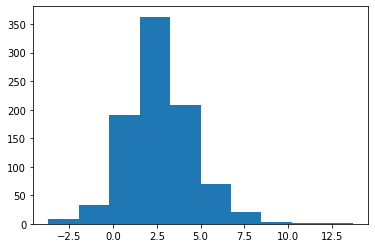

In [ ]:
plt.hist(delaney_dataset.y)

(-3.5, 13.5)

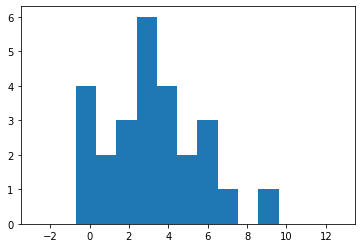

In [ ]:
_ = plt.hist(comp_lkp_xlogp.xlogp)
plt.xlim(-3.5, 13.5)

In [ ]:
data_dir = os.path.join(paper_dir, 'deepchem_dataset')
X = comp_lkp_xlogp.ConvMol.values
y = comp_lkp_xlogp.xlogp
visc_dataset = dc.data.DiskDataset.from_numpy(X=X, y=y, data_dir=data_dir)

In [ ]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

In [ ]:
datasets

(<DiskDataset X.shape: (902,), y.shape: (902, 1), w.shape: (902, 1), ids: ['CC(C)=CCCC(C)=CC(=O)' 'CCCC=C' 'CCCCCCCCCCCCCC' ...
  'Nc2cccc3nc1ccccc1cc23 ' 'C1CCCCCC1' 'OC1CCCCCC1'], task_names: ['measured log solubility in mols per litre']>,
 <DiskDataset X.shape: (113,), y.shape: (113, 1), w.shape: (113, 1), ids: ['Nc1ncnc2nc[nH]c12 ' 'Nc1nc(O)nc2nc[nH]c12 '
  'Fc1cccc(F)c1C(=O)NC(=O)Nc2cc(Cl)c(F)c(Cl)c2F ' ...
  'OC(Cn1cncn1)(Cn2cncn2)c3ccc(F)cc3F '
  'FC(F)(F)c1cccc(c1)N2CC(CCl)C(Cl)C2=O' 'CC1(C)CON(Cc2ccccc2Cl)C1=O'], task_names: ['measured log solubility in mols per litre']>,
 <DiskDataset X.shape: (113,), y.shape: (113, 1), w.shape: (113, 1), ids: ['c1cc2ccc3cccc4ccc(c1)c2c34' 'Cc1cc(=O)[nH]c(=S)[nH]1'
  'Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 ' ...
  'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43' 'Cc1occc1C(=O)Nc2ccccc2'
  'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '], task_names: ['measured log solubility in mols per litre']>)

In [ ]:
#n_tasks = len(tasks)
model = dc.models.GraphConvModel(n_tasks = 1, mode='regression')

In [ ]:
model.fit(delaney_dataset, nb_epoch=100)

0.051391077041625974

In [ ]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('training set score:', model.evaluate(delaney_dataset, [metric]))
print('test set score:', model.evaluate(visc_dataset, [metric]))

training set score: {'pearson_r2_score': 0.9926120422211057}
test set score: {'pearson_r2_score': 0.7935199875408895}


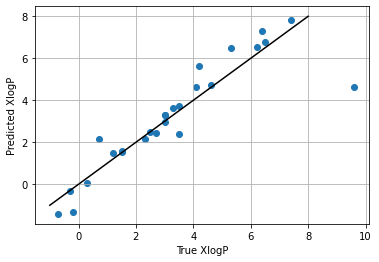

In [ ]:
# Despues de 1 epochs
_ = plt.scatter(visc_dataset.y, model.predict(visc_dataset))
plt.xlabel('True XlogP')
plt.ylabel('Predicted XlogP')
#plt.xlim(-1, 10)
#plt.ylim(-1, 10)
plt.plot([-1, 8],[-1, 8], color = 'black')
plt.grid()

In [ ]:
model.fit(disk_dataset, nb_epoch=50)

0.004550777971744537

In [ ]:
comp_lkp_xlogp.xlogp.values

array([ 1.5,  1.5,  1.2, -0.3, -0.2, -0.7,  3.5,  0.3,  3.3,  0.7,  3. ,
        3. ,  3. ,  3.5,  6.5,  4.1,  4.2,  5.3,  6.4,  7.4,  6.2,  4.6,
        9.6,  2.3,  2.5,  2.7])

In [ ]:
visc_dataset.y

array([ 1.5,  1.5,  1.2, -0.3, -0.2, -0.7,  3.5,  0.3,  3.3,  0.7,  3. ,
        3. ,  3. ,  3.5,  6.5,  4.1,  4.2,  5.3,  6.4,  7.4,  6.2,  4.6,
        9.6,  2.3,  2.5,  2.7])

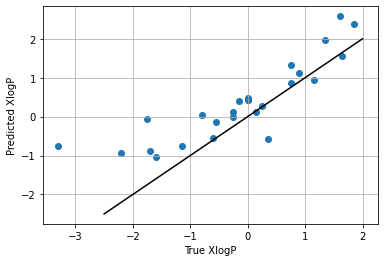

In [ ]:
# Despues de 1 epochs
_ = plt.scatter(-0.5*visc_dataset.y+1.5, model.predict(visc_dataset))
plt.xlabel('True XlogP')
plt.ylabel('Predicted XlogP')
#plt.xlim(-1, 10)
#plt.ylim(-1, 10)
plt.plot([-2.5, 2],[-2.5, 2], color = 'black')
plt.grid()

In [ ]:
model.fit(disk_dataset, nb_epoch=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_5/Reshape_14:0", shape=(336,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_5/Reshape_13:0", shape=(336, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_5/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_5/Reshape_17:0", shape=(1386,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_5/

0.16402814865112306

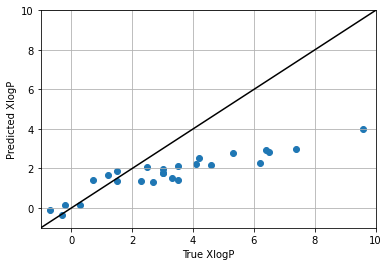

In [ ]:
# Despues de 51 epochs
_ = plt.scatter(disk_dataset.y, model.predict(disk_dataset))
plt.xlabel('True XlogP')
plt.ylabel('Predicted XlogP')
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.plot([-1, 10],[-1, 10], color = 'black')
plt.grid()

In [ ]:
model.fit(disk_dataset, nb_epoch=49)

0.0012454612522709127

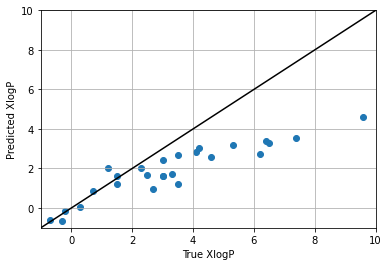

In [ ]:
# Despues de 100 epochs
_ = plt.scatter(disk_dataset.y, model.predict(disk_dataset))
plt.xlabel('True XlogP')
plt.ylabel('Predicted XlogP')
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.plot([-1, 10],[-1, 10], color = 'black')
plt.grid()

In [ ]:
model.fit(disk_dataset, nb_epoch=200)

0.0006295995414257049

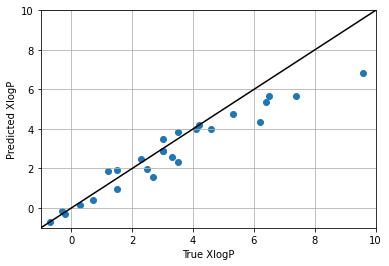

In [ ]:
# Despues de 300 epochs
_ = plt.scatter(disk_dataset.y, model.predict(disk_dataset))
plt.xlabel('True XlogP')
plt.ylabel('Predicted XlogP')
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.plot([-1, 10],[-1, 10], color = 'black')
plt.grid()

In [ ]:
model.fit(disk_dataset, nb_epoch=50)
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

In [ ]:
help(comps_features[0])

Help on ConvMol in module deepchem.feat.mol_graphs object:

class ConvMol(builtins.object)
 |  ConvMol(atom_features, adj_list, max_deg=10, min_deg=0)
 |  
 |  Holds information about a molecules.
 |  
 |  Resorts order of atoms internally to be in order of increasing degree. Note
 |  that only heavy atoms (hydrogens excluded) are considered here.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, atom_features, adj_list, max_deg=10, min_deg=0)
 |      Parameters
 |      ----------
 |      atom_features: np.ndarray
 |        Has shape (n_atoms, n_feat)
 |      adj_list: list
 |        List of length n_atoms, with neighor indices of each atom.
 |      max_deg: int, optional
 |        Maximum degree of any atom.
 |      min_deg: int, optional
 |        Minimum degree of any atom.
 |  
 |  get_adjacency_list(self)
 |      Returns a canonicalized adjacency list.
 |      
 |      Canonicalized means that the atoms are re-ordered by degree.
 |      
 |      Returns
 |      -------
 |    